### Imports

In [1]:
first_time_importing_torch = True

In [2]:
import os

import time
# NOTE: Importing torch the first time will always take a long time!
if first_time_importing_torch:
    print(f"Importing torch ...")
    import_torch_start_time = time.time() 
import torch
if first_time_importing_torch:
    import_torch_end_time = time.time()
    print(f"Importing torch took {import_torch_end_time - import_torch_start_time} seconds")
    first_time_importing_torch = False

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import datetime

from PIL import Image

# Optional
from tqdm import tqdm # progress bar

import wandb # Optional, for logging

import json
import yaml

from ignite.metrics import PSNR, SSIM, MeanSquaredError
from ignite.engine import Engine

Importing torch ...
Importing torch took 10.207419633865356 seconds


In [3]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/venv/bin/python
Torch version: 2.3.0+cu121
Path: /mnt/c/Users/t/Documents/GIT/DISSERTATION/LearningRegularizationParameterMaps/sidd


In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
DISABLING_TESTS = False
# DISABLING_TESTS = True   # Disable tests for less output

### Use GPU

In [6]:
# if torch.cuda.is_available():
#     DEVICE = torch.device("cuda")
#     print(f"Using {torch.cuda.get_device_name(0)}")
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
#     print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
# else:
#     DEVICE = torch.device("cpu")
#     print("Using CPU")

DEVICE = "cpu"

torch.set_default_device(DEVICE)

### CONFIG

In [7]:
def get_config():
    return {
        "project_name": "SIDD",
        "architecture": "UNET-PDHG",
        "data": {
            "dataset": "Static Image Denoising Dataset",
            "original_dataset": "https://abdokamel.github.io/sidd/",
            "path": "data/images",
            "train_num_samples": 800,
            "val_num_samples": 100,
            "test_num_samples": 100,
            "patch_size": 256,
            "random_seed_split": 42,
        },
        "noise": {
            "min_sigma": 0.1,
            "max_sigma": 0.5,
            "random_seed_noise": 97,
        },
        "unet": {
            "in_channels": 1,
            "out_channels": 2,
            "init_filters": 32,
            "n_blocks": 3,
            "activation": "LeakyReLU",
            "downsampling_kernel": (2, 2, 1),
            "downsampling_mode": "max",
            "upsampling_kernel": (2, 2, 1),
            "upsampling_mode": "linear_interpolation",
        },
        "pdhg": {
            # "up_bound": 0.5,
            "up_bound": 0,
            "T_train": 128,  # Higher T, NET does not have to try as hard? Less overfitting?
        },
        "training": {
            "optimizer": "Adam",
            "learning_rate": 1e-4,
            "loss_function": "MSELoss",
            "epochs": 10_000,
            "batch_size": 1,
            "manual_seed": 42,
        },
        "evaluation": {
            "metrics": ["SSIM", "PSNR"],
        },
        # "device": "cuda:0",
        "device": "cpu",
        "others": {
            "wandb_mode": "online",
            "save_epoch_wandb": 10,
            "save_epoch_local": 2,
            "save_dir": "models",
        }
    }

print(get_config())

{'project_name': 'SIDD', 'architecture': 'UNET-PDHG', 'data': {'dataset': 'Static Image Denoising Dataset', 'original_dataset': 'https://abdokamel.github.io/sidd/', 'path': 'data/images', 'train_num_samples': 800, 'val_num_samples': 100, 'test_num_samples': 100, 'patch_size': 256, 'random_seed_split': 42}, 'noise': {'min_sigma': 0.1, 'max_sigma': 0.5, 'random_seed_noise': 97}, 'unet': {'in_channels': 1, 'out_channels': 2, 'init_filters': 32, 'n_blocks': 3, 'activation': 'LeakyReLU', 'downsampling_kernel': (2, 2, 1), 'downsampling_mode': 'max', 'upsampling_kernel': (2, 2, 1), 'upsampling_mode': 'linear_interpolation'}, 'pdhg': {'up_bound': 0, 'T_train': 128}, 'training': {'optimizer': 'Adam', 'learning_rate': 0.0001, 'loss_function': 'MSELoss', 'epochs': 10000, 'batch_size': 1, 'manual_seed': 42}, 'evaluation': {'metrics': ['SSIM', 'PSNR']}, 'device': 'cpu', 'others': {'wandb_mode': 'online', 'save_epoch_wandb': 10, 'save_epoch_local': 2, 'save_dir': 'models'}}


### Download the data

In [8]:
# # REMEMBER TO COMMENT THIS OUT IF THE DATA HAS BEEN DOWNLOADED!
# !wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2
# !unzip "a26784fe-cf33-48c2-b61f-94b299dbc0f2" -d .

------

### Data loading class

In [9]:
class SiddDataset(Dataset):
	def __init__(
		self, 
		data_path: str,
		num_samples: int,
		device: str = "cuda"
	):
		folders = os.listdir(data_path)
		assert len(folders) >= num_samples, f"Number of samples requested ({num_samples}) is greater than the number of folders ({len(folders)})"
		print(f"Loading {num_samples} images ...")
		self.image_pairs = []
		# Shuffle the folders
		np.random.shuffle(folders)
		for i in tqdm(range(num_samples)):
			folder = folders[i]
			clean_im = Image.open(os.path.join(data_path, folder, "clean.png"))
			noisy_im = Image.open(os.path.join(data_path, folder, "noisy.png"))

			# clean_im = clean_im.convert("L")
			# noisy_im = noisy_im.convert("L")

			clean_np = np.asarray(clean_im)
			noisy_np = np.asarray(noisy_im)

			# Convert to tensor and normalise from [0, 255] to [0, 1]
			clean_im_tensor = torch.tensor(clean_np, dtype=torch.float).to(device) / 255
			noisy_im_tensor = torch.tensor(noisy_np, dtype=torch.float).to(device) / 255
			# Add channel and "time" dimensions: (256, 256) -> (1, 256, 256, 1)
			clean_im_tensor_4D = clean_im_tensor.unsqueeze(0).unsqueeze(-1)
			noisy_im_tensor_4D = noisy_im_tensor.unsqueeze(0).unsqueeze(-1)
			self.image_pairs.append((noisy_im_tensor_4D, clean_im_tensor_4D))

			# clean_max = clean_im_tensor.max().item()
			# clean_min = clean_im_tensor.min().item()
			# noisy_max = noisy_im_tensor.max().item()
			# noisy_min = noisy_im_tensor.min().item()
			# print(f"Clean: max={clean_max}, min={clean_min}")
			# print(f"Noisy: max={noisy_max}, min={noisy_min}")
			# assert clean_max <= 1.0 and clean_min >= 0.0, f"Clean image has values outside [0, 1]: max={clean_max}, min={clean_min}"
			# assert noisy_max <= 1.0 and noisy_min >= 0.0, f"Noisy image has values outside [0, 1]: max={noisy_max}, min={noisy_min}"

		print(f"Finished loading {num_samples} images")

	def __getitem__(self, index):
		# noisy_im, clean_im = self.image_pairs[index]
		# noisy_max = noisy_im.max().item()
		# noisy_min = noisy_im.min().item()
		# clean_max = clean_im.max().item()
		# clean_min = clean_im.min().item()
		# print(f"Noisy: max={noisy_max}, min={noisy_min}")
		# print(f"Clean: max={clean_max}, min={clean_min}")
		# assert noisy_max <= 1.0 and noisy_min >= 0.0, f"Noisy image has values outside [0, 1]: max={noisy_max}, min={noisy_min}"
		# assert clean_max <= 1.0 and clean_min >= 0.0, f"Clean image has values outside [0, 1]: max={clean_max}, min={clean_min}"
		return self.image_pairs[index]
		
	def __len__(self):
		return len(self.image_pairs)

### Explore Data

In [10]:
def test_load_sidd_images():
    data_path = "data/images/train"
    print(f"Data path: {data_path}")
    dataset = SiddDataset(data_path, 10)
    print(f"Number of files: {len(dataset)}")

test_load_sidd_images()

Data path: data/images/train
Loading 10 images ...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 34.78it/s]

Finished loading 10 images
Number of files: 10


PSNR: 18.32 | SSIM: 0.13


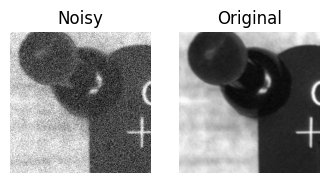

PSNR: 19.51 | SSIM: 0.13


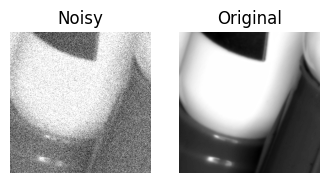

PSNR: 23.77 | SSIM: 0.24


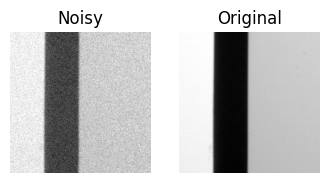

PSNR: 19.84 | SSIM: 0.23


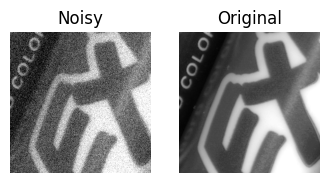

PSNR: 25.82 | SSIM: 0.36


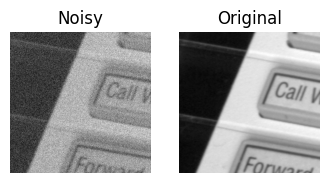

PSNR: 29.20 | SSIM: 0.53


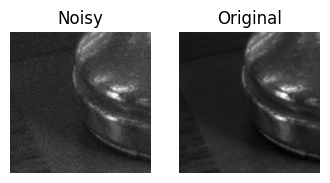

PSNR: 24.26 | SSIM: 0.29


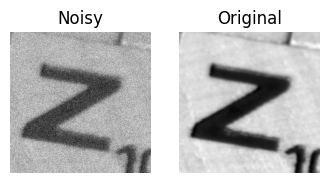

In [11]:
def get_examples():
    data_path = "data/images/val"
    examples = [
        "0016_GT_SRGB_010_1",
        "0051_GT_SRGB_011_8",
        "0023_GT_SRGB_010_25",
        # "0013_GT_SRGB_011_16",
        "0044_GT_SRGB_011_5",
        # "0044_GT_SRGB_010_27",
        # "0044_GT_SRGB_011_19",
        "0055_GT_SRGB_010_2",
        # "0077_GT_SRGB_010_5",
        "0078_GT_SRGB_010_20",
        "0142_GT_SRGB_011_26"
    ]

    image_tensors = []

    for example in examples:
        folder = f"{data_path}/{example}"
        clean_img = Image.open(f"{folder}/clean.PNG")
        noisy_img = Image.open(f"{folder}/noisy.PNG")

        clean_img_np = np.array(clean_img)
        noisy_img_np = np.array(noisy_img)

        clean_img_tensor = torch.tensor(clean_img_np, dtype=torch.float32) / 255.0
        noisy_img_tensor = torch.tensor(noisy_img_np, dtype=torch.float32) / 255.0
        image_tensors.append((clean_img_tensor, noisy_img_tensor))
    return image_tensors



def show_examples():
    tensors_2D = get_examples()

    def eval_step(engine, batch):
        return batch

    default_evaluator = Engine(eval_step)

    psnr = PSNR(data_range=1.0)
    psnr.attach(default_evaluator, 'psnr')
    ssim = SSIM(data_range=1.0)
    ssim.attach(default_evaluator, 'ssim')

    for clean_img, noisy_img in tensors_2D:
        # Add batch and channel dimensions: (H, W) -> (1, 1, H, W)
        clean_img_4D = clean_img.unsqueeze(0).unsqueeze(0) 
        noisy_img_4D = noisy_img.unsqueeze(0).unsqueeze(0)

        state = default_evaluator.run([(clean_img_4D, noisy_img_4D)])

        print(f"PSNR: {state.metrics['psnr']:.2f} | SSIM: {state.metrics['ssim']:.2f}")

        clean_img = clean_img.to("cpu")
        noisy_img = noisy_img.to("cpu")

        plt.figure(figsize=(4, 2))
  
        plt.subplot(1, 2, 1)
        plt.imshow(noisy_img, cmap="gray")
        plt.title("Noisy")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(clean_img, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.show();
    
        del clean_img, noisy_img
        del state

    del default_evaluator
    del psnr, ssim

show_examples()

### ClipAct

In [12]:
class ClipAct(nn.Module):
    def forward(self, x, threshold):
        return clipact(x, threshold)


def clipact(x, threshold):
    is_complex = x.is_complex()
    if is_complex:
        x = torch.view_as_real(x)
        threshold = threshold.unsqueeze(-1)
    x = torch.clamp(x, -threshold, threshold)
    if is_complex:
        x = torch.view_as_complex(x)
    return x

### Grad Ops

In [13]:

class GradOperators(torch.nn.Module):
    @staticmethod
    def diff_kernel(ndim, mode):
        if mode == "doublecentral":
            kern = torch.tensor((-1, 0, 1))
        elif mode == "central":
            kern = torch.tensor((-1, 0, 1)) / 2
        elif mode == "forward":
            kern = torch.tensor((0, -1, 1))
        elif mode == "backward":
            kern = torch.tensor((-1, 1, 0))
        else:
            raise ValueError(f"mode should be one of (central, forward, backward, doublecentral), not {mode}")
        kernel = torch.zeros(ndim, 1, *(ndim * (3,)))
        for i in range(ndim):
            idx = tuple([i, 0, *(i * (1,)), slice(None), *((ndim - i - 1) * (1,))])
            kernel[idx] = kern
        return kernel

    def __init__(self, dim:int=2, mode:str="doublecentral", padmode:str = "circular"):
        """
        An Operator for finite Differences / Gradients
        Implements the forward as apply_G and the adjoint as apply_GH.
        
        Args:
            dim (int, optional): Dimension. Defaults to 2.
            mode (str, optional): one of doublecentral, central, forward or backward. Defaults to "doublecentral".
            padmode (str, optional): one of constant, replicate, circular or refelct. Defaults to "circular".
        """
        super().__init__()
        self.register_buffer("kernel", self.diff_kernel(dim, mode), persistent=False)
        self._dim = dim
        self._conv = (torch.nn.functional.conv1d, torch.nn.functional.conv2d, torch.nn.functional.conv3d)[dim - 1]
        self._convT = (torch.nn.functional.conv_transpose1d, torch.nn.functional.conv_transpose2d, torch.nn.functional.conv_transpose3d)[dim - 1]
        self._pad = partial(torch.nn.functional.pad, pad=2 * dim * (1,), mode=padmode)
        if mode == 'central':
            self._norm = (self.dim) ** (1 / 2)
        else:
            self._norm = (self.dim * 4) ** (1 / 2)

    @property
    def dim(self):
        return self._dim
    
    def apply_G(self, x):
        """
        Forward
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim], self.dim, *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[0 : -self.dim], self.dim, *x.shape[-self.dim :])

        del x, xr, xp

        return y

    def apply_GH(self, x):
        """
        Adjoint
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, self.dim, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._convT(xp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim - 1], *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[: -self.dim - 1], *x.shape[-self.dim :])

        del x, xr, xp

        return y
    
    def apply_GHG(self, x):
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        tmp = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        tmp = self._pad(tmp)
        y = self._convT(tmp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape)
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape)

        del x, xr, xp, tmp

        return y

    def forward(self, x, direction=1):
        if direction>0:
            return self.apply_G(x)
        elif direction<0:
            return self.apply_GH(x)
        else:
            return self.apply_GHG(x)

    @property
    def normGHG(self):
        return self._norm



### PDHG 5D

In [14]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

def pdhg_5D(
        x_dynamic_image_tensor_5D, lambda_reg, T, 
):
    """
    Reconstructs the image using the PDHG algorithm.

    Parameters:
        dynamic_image_tensor_5D: The (noisy) (dynamic) image tensor.
        Size of the tensor: (`patches`, `channels`, `Nx`, `Ny`, `Nt`) where
        
        - `patches`: number of patches
        - `channels`: number of (colour) channels
        - `Nx`: number of pixels in x
        - `Ny`: number of pixels in y
        - `Nt`: number of time steps (frames)

        lambda_reg: The regularization parameter. Can be a scalar or a tensor of suitable size.
        T: Number of iterations.

    Returns:
        The reconstructed image tensor.
    """

    dim = 3
    patches, channels, Nx, Ny, Nt = x_dynamic_image_tensor_5D.shape
    
    assert channels == 1, "Only grayscale images are supported."

    device = x_dynamic_image_tensor_5D.device

    # starting values
    xbar = x_dynamic_image_tensor_5D.clone()
    x0 = x_dynamic_image_tensor_5D.clone()
    xnoisy = x_dynamic_image_tensor_5D.clone()

    # dual variable
    p = x_dynamic_image_tensor_5D.clone()
    q = torch.zeros(patches, dim, Nx, Ny, Nt, dtype=x_dynamic_image_tensor_5D.dtype).to(device)

    # operator norms
    op_norm_AHA = torch.sqrt(torch.tensor(1.0))
    op_norm_GHG = torch.sqrt(torch.tensor(12.0))
    # operator norm of K = [A, \nabla]
    # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
    # see page 3083
    L = torch.sqrt(op_norm_AHA**2 + op_norm_GHG**2)

    tau = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L
    sigma = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L

    # theta should be in \in [0,1]
    theta = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1

    # sigma, tau, theta
    sigma = (1 / L) * torch.sigmoid(sigma)  # \in (0,1/L)
    tau = (1 / L) * torch.sigmoid(tau)  # \in (0,1/L)
    theta = torch.sigmoid(theta)  # \in (0,1)

    GradOps = GradOperators(
        dim=dim, 
        mode="forward", padmode="circular")
    clip_act = ClipAct()
    # Algorithm 2 - Unrolled PDHG algorithm (page 18)
    # TODO: In the paper, L is one of the inputs but not used anywhere in the pseudo code???
    for kT in range(T):
        # update p
        p =  (p + sigma * (xbar - xnoisy) ) / (1. + sigma)
        # update q
        q = clip_act(q + sigma * GradOps.apply_G(xbar), lambda_reg)

        x1 = x0 - tau * p - tau * GradOps.apply_GH(q)

        if kT != T - 1:
            # update xbar
            xbar = x1 + theta * (x1 - x0)
            x0 = x1

    del x_dynamic_image_tensor_5D
    del xbar, x0, xnoisy
    del p, q
    del op_norm_AHA, op_norm_GHG, L
    del tau, sigma, theta
    del GradOps
    del clip_act

    return x1

PSNR: 18.99, SSIM: 0.23


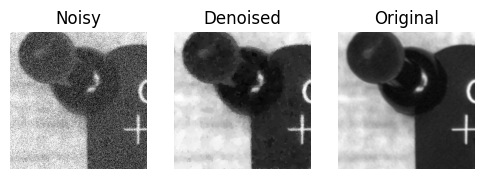

PSNR: 20.19, SSIM: 0.21


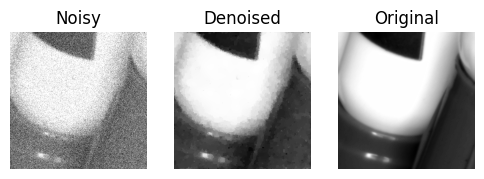

PSNR: 23.90, SSIM: 0.25


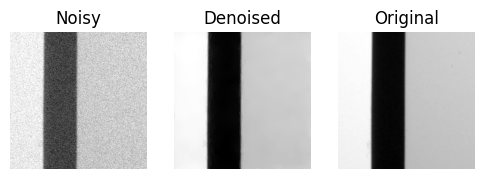

PSNR: 20.54, SSIM: 0.30


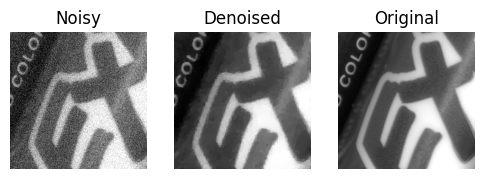

PSNR: 25.73, SSIM: 0.35


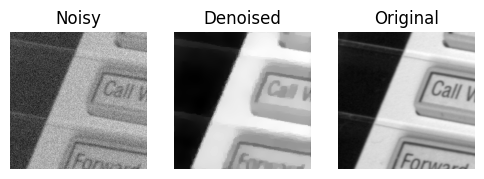

PSNR: 28.61, SSIM: 0.50


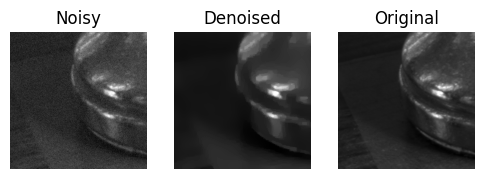

PSNR: 24.48, SSIM: 0.31


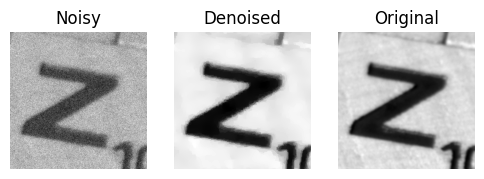

In [15]:
# Test denoising with PDHG
def test_denoise_pdhg(lambda_reg = 0.08, T = 128):

    tensors_2D = get_examples()

    # create default evaluator for doctests
    def eval_step(engine, batch):
        return batch
    
    default_evaluator = Engine(eval_step)
    
    psnr = PSNR(data_range=1.0)
    psnr.attach(default_evaluator, 'psnr')
    ssim = SSIM(data_range=1.0)
    ssim.attach(default_evaluator, 'ssim')

    for clean_image_2D, noisy_image_2D in tensors_2D:

        # Add batch, channel and "time" dimensions: (256, 256) -> (1, 1, 256, 256, 1)
        noisy_image_tensor_5D = noisy_image_2D.unsqueeze(0).unsqueeze(0).unsqueeze(-1)

        denoised_image_tensor_5D = pdhg_5D(
            noisy_image_tensor_5D, 
            lambda_reg=lambda_reg, 
            T=128
        )
        
        denoised_image_tensor_5D = torch.clamp(denoised_image_tensor_5D, 0, 1) # Clip the values to 0 and 1

        # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)
        denoised_image_tensor_4D = denoised_image_tensor_5D.squeeze(-1)
        noisy_image_tensor_4D = noisy_image_tensor_5D.squeeze(-1)

        state = default_evaluator.run([[denoised_image_tensor_4D, noisy_image_tensor_4D]])
        print(f"PSNR: {state.metrics['psnr']:.2f}, SSIM: {state.metrics['ssim']:.2f}")

        # Remove the channel and "time" dimension: (1, 256, 256, 1) -> (256, 256)
        clean_image_2D = clean_image_2D.to("cpu").detach().numpy()
        noisy_image_2D = noisy_image_2D.to("cpu").detach().numpy()

        # Remove the batch and channel dimension: (1, 1, 256, 256) -> (256, 256)
        denoised_image_2D = denoised_image_tensor_4D.squeeze(0).squeeze(0).to("cpu").detach().numpy()
        
        plt.figure(figsize=(6, 2))

        plt.subplot(1, 3, 1)
        plt.imshow(noisy_image_2D, cmap="gray")
        plt.axis("off")
        plt.title("Noisy")

        plt.subplot(1, 3, 2)
        plt.imshow(denoised_image_2D, cmap="gray")
        plt.axis("off")
        plt.title("Denoised")
  
        plt.subplot(1, 3, 3)
        plt.imshow(clean_image_2D, cmap="gray")
        plt.axis("off")
        plt.title("Original")
  
        plt.show();

test_denoise_pdhg(lambda_reg=0.08, T=128)


------

### Full Architecture

<!-- UNET to PDHG

The whole architecture can be seen as unsupervised: The data only contains (clean) images.

The whole model: Input is an image. Output is also an image.

The UNET actually only outputs the regularisation parameter map. -->

In [16]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

class PrimalDualNN(nn.Module):
    def __init__(
        self,
        T=128,
        cnn_block=None,
        up_bound=0,
        phase="training",
    ):
        super(PrimalDualNN, self).__init__()

        # gradient operators and clipping function
        dim = 3
        self.GradOps = GradOperators(dim, mode="forward", padmode="circular")

        # operator norms
        self.op_norm_AHA = torch.sqrt(torch.tensor(1.0))
        self.op_norm_GHG = torch.sqrt(torch.tensor(12.0))
        # operator norm of K = [A, \nabla]
        # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
        # see page 3083
        self.L = torch.sqrt(self.op_norm_AHA**2 + self.op_norm_GHG**2)

        # function for projecting
        self.ClipAct = ClipAct()

        # the CNN-block to estimate the lambda regularization map
        # must be a CNN yielding a two-channeld output, i.e.
        # one map for lambda_cnn_xy and one map for lambda_cnn_t
        self.cnn = cnn_block    # NOTE: This is actually the UNET!!! (At least in this project)
        self.up_bound = torch.tensor(up_bound)

        # number of terations
        self.T = T

        # constants depending on the operators
        self.tau = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L
        self.sigma = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L

        # theta should be in \in [0,1]
        self.theta = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1

        # distinguish between training and test phase;
        # during training, the input is padded using "reflect" padding, because
        # patches are used by reducing the number of temporal points;
        # while testing, "reflect" padding is used in x,y- direction, while
        # circular padding is used in t-direction
        self.phase = phase

    def get_lambda_cnn(self, x):
        # padding
        # arbitrarily chosen, maybe better to choose it depending on the
        # receptive field of the CNN or so;
        # seems to be important in order not to create "holes" in the
        # lambda_maps in t-direction
        npad_xy = 4
        # npad_t = 8
        npad_t = 0 # TODO: Time dimension should not be necessary for single image input.
        # I changed the npad_t to 0 so that I can run on single image input without change the 3D type config. It seems that the number of frames must be greater than npad_t?

        pad = (npad_t, npad_t, npad_xy, npad_xy, npad_xy, npad_xy)

        if self.phase == "training":
            x = F.pad(x, pad, mode="reflect")

        elif self.phase == "testing":
            pad_refl = (0, 0, npad_xy, npad_xy, npad_xy, npad_xy)
            pad_circ = (npad_t, npad_t, 0, 0, 0, 0)

            x = F.pad(x, pad_refl, mode="reflect")
            x = F.pad(x, pad_circ, mode="circular")

        # estimate parameter map
        lambda_cnn = self.cnn(x) # NOTE: The cnn is actually the UNET block!!! (At least in this project)

        # crop
        neg_pad = tuple([-pad[k] for k in range(len(pad))])
        lambda_cnn = F.pad(lambda_cnn, neg_pad)

        # double spatial map and stack
        lambda_cnn = torch.cat((lambda_cnn[:, 0, ...].unsqueeze(1), lambda_cnn), dim=1)

        # constrain map to be striclty positive; further, bound it from below
        if self.up_bound > 0:
            # constrain map to be striclty positive; further, bound it from below
            lambda_cnn = self.up_bound * self.op_norm_AHA * torch.sigmoid(lambda_cnn)
        else:
            lambda_cnn = 0.1 * self.op_norm_AHA * F.softplus(lambda_cnn)

        del pad
        del x
        del neg_pad

        return lambda_cnn

    def forward(
            self, x, lambda_map=None, 
            # lambda_reg_container=None,
    ):
        if lambda_map is None:
            # estimate lambda reg from the image
            lambda_reg = self.get_lambda_cnn(x)
        else:
            lambda_reg = lambda_map

        # if lambda_reg_container is not None:
        #     assert type(lambda_reg_container) == list, f"lambda_reg_container should be a list, not {type(lambda_reg_container)}"
        #     lambda_reg_container.append(lambda_reg) # For comparison

        x.to(DEVICE)
        x1 = pdhg_5D(x, lambda_reg, self.T)

        del lambda_reg
        del x

        return x1

------

### UNET

In [17]:
# Used https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py as a reference

class DoubleConv(nn.Module):
    def __init__(
            self, in_channels: int, out_channels: int, n_dimensions=3, activation="LeakyReLU"):
        super(DoubleConv, self).__init__()

        def get_conv(in_channels, out_channels):
            # 1-dimensional convolution is not supported
            if n_dimensions == 3:
                return nn.Conv3d(in_channels, out_channels, kernel_size=(3, 3, 1), padding=(1, 1, 0))
            elif n_dimensions == 2:
                return nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
            else:
                raise ValueError(f"Unsupported number of dimensions: {n_dimensions}")

        def get_activation():
            if activation == "LeakyReLU":
                return nn.LeakyReLU(negative_slope=0.01, inplace=True)
            elif activation == "ReLU":
                return nn.ReLU(inplace=True)
            else:
                raise ValueError(f"Unsupported activation function: {activation}")

        self.conv_block = nn.Sequential(
            get_conv(in_channels, out_channels), get_activation(),
            get_conv(out_channels, out_channels), get_activation())

    def forward(self, x: torch.Tensor):
        return self.conv_block(x)
        

class EncodeBlock3d(nn.Module):
    def __init__(
            self, in_channels: int, n_dimensions=3,
            activation="LeakyReLU",
            downsampling_kernel=(2, 2, 1), downsampling_mode="max"):
        super(EncodeBlock3d, self).__init__()

        len = downsampling_kernel[0] # Assume kernel has shape (len, len, 1)
        assert downsampling_kernel == (len, len, 1), f"Expected a flat square kernel like {(len, len, 1)}, got {downsampling_kernel}"
        stride = (2, 2, 1) # Stride 2x2 to halve each side 
        padding = ((len-1)//2, (len-1)//2, 0) # Padding (len-1) // 2 to exactly halve each side 
        if downsampling_mode == "max":
            self.pool = nn.MaxPool3d(
                kernel_size=downsampling_kernel, stride=stride, padding=padding)
        elif downsampling_mode == "avg":
            self.pool = nn.AvgPool3d(
                kernel_size=downsampling_kernel, stride=stride, padding=padding)
        else:
            raise ValueError(f"Unknown pooling method: {downsampling_mode}")

        self.double_conv = DoubleConv(in_channels, in_channels * 2, n_dimensions, activation=activation)

    def forward(self, x: torch.Tensor):
        x = self.pool(x)
        x = self.double_conv(x)
        return x



class DecodeBlock3d(nn.Module):
    def __init__(
            self, in_channels: int, n_dimensions=3, 
            activation="LeakyReLU",
            upsampling_kernel=(2, 2, 1), upsampling_mode="linear_interpolation"):
        super(DecodeBlock3d, self).__init__()

        if upsampling_mode == "linear_interpolation":
            self.upsampling = nn.Sequential(
                nn.Upsample(
                    scale_factor=(2, 2, 1), # Assume the shape is (Nx, Ny, 1) where Nx is the image width and Ny is the image height.
                    mode='trilinear', align_corners=True), # What difference does it make in the end if align_corners is True or False? Preserving symmetry?
                # 1x1x1 convolution to reduce the number of channels while keeping the size the same
                nn.Conv3d(
                    in_channels, in_channels // 2, 
                    kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(0, 0, 0))
            )
        elif upsampling_mode == "transposed_convolution":  
            len = upsampling_kernel[0] # Assume kernel has shape (len, len, 1)
            assert upsampling_kernel == (len, len, 1), f"Expected a flat square kernel like {(len, len, 1)}, got {upsampling_kernel}"
            stride = (2, 2, 1) # Stride 2x2 to double each side 
            padding = ((len-1)//2, (len-1)//2, 0) # Padding (len-1) // 2 to exactly double each side    
            self.upsampling = nn.ConvTranspose3d(
                in_channels, in_channels // 2, 
                kernel_size=upsampling_kernel, stride=stride, padding=padding, 
                output_padding=padding # TODO: Should this be the same as padding?
            )
        else:
            raise ValueError(f"Unsupported upsampling method: {upsampling_mode}")
        
        self.double_conv = DoubleConv(in_channels, in_channels // 2, n_dimensions, activation=activation)

    def forward(self, x: torch.Tensor, x_encoder_output: torch.Tensor):
        x = self.upsampling(x)
        x = torch.cat([x_encoder_output, x], dim=1)   # skip-connection. No cropping since we ensure that the size is the same.
        x = self.double_conv(x)
        return x



class UNet3d(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=2, init_filters=32, n_blocks=3,
            activation="LeakyReLU",
            downsampling_kernel=(2, 2, 1), downsampling_mode="max",
            upsampling_kernel=(2, 2, 1), upsampling_mode="linear_interpolation",
    ):
        """
        Assume that input is 5D tensor of shape (batch_size, channels, Nx, Ny, Nt)
        where Nx is the image width and Ny is the image height.
        Assume that batch_size = 1, channels = 1, Nx = Ny (square image), Nt = 1 (static image).
        NOTE: The convention used in pytorch documentation is (batch_size, channels, Nt, Ny, Nx).
        "channels" is equivalent to the number of filters or features.

        Our paper (figure 2):
            - in_channels = 1
            - out_channels = 2
            - init_filters = 32
            - n_blocks = 3
            - pooling: max pooling 2x2
            - pool padding = 1
                - 1 padding will keep the size of the "image" the same after each convolution. The skip-connection will NOT crop the encoder's output.
            - upsampling kernel: 2x2 ?
            - up_mode: linear interpolation

        U-Net paper (2015, Olaf Ronneberger https://arxiv.org/abs/1505.04597):
            - in_channels = 1
            - out_channels = 2
            - init_filters = 64
            - n_blocks = 4
            - pooling: max pooling 2x2
            - pool padding = 0
                - 0 padding will reduce the size of the "image" by 2 in each dimension after each convolution. The skip-connection will have to crop the encoder's output to match the decoder's input.
            - upsampling kernel: 2x2
            - up_mode: ? (linear interpolation or transposed convolution)
        """
        super(UNet3d, self).__init__()

        print(f"U-Net config: in_channels={in_channels}, out_channels={out_channels}, init_filters={init_filters}, n_blocks={n_blocks}, activation={activation}, downsampling_kernel={downsampling_kernel}, downsampling_mode={downsampling_mode}, upsampling_kernel={upsampling_kernel}, upsampling_mode={upsampling_mode}")
        
        self.c0x0 = DoubleConv( # TODO: Find a better name
            in_channels=in_channels, 
            out_channels=init_filters,
            activation=activation
        )
        self.encoder = nn.ModuleList([
            EncodeBlock3d(
                in_channels=init_filters * 2**i,
                activation=activation,
                downsampling_kernel=downsampling_kernel,
                downsampling_mode=downsampling_mode
            ) for i in range(n_blocks)
        ])
        self.decoder = nn.ModuleList([
            DecodeBlock3d(
                in_channels=init_filters * 2**(n_blocks-i),
                activation=activation, 
                upsampling_kernel=upsampling_kernel,
                upsampling_mode=upsampling_mode
            ) for i in range(n_blocks)
        ])
        # 1x1x1 convo
        self.c1x1 = nn.Conv3d( # TODO: Find a better name
            in_channels=init_filters,
            out_channels=out_channels,
            kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(0, 0, 0)
        )

    def forward(self, x: torch.Tensor):
        # Assume that x is 5D tensor of shape (batch_size, channels, Nx, Ny, Nt)
        # where Nx is the image width and Ny is the image height.
        # Aslo assume that batch_size = 1, channels = 1, Nx = Ny (square image), Nt = 1 (static image).
        # NOTE: The convention used in pytorch documentation is (batch_size, channels, Nt, Ny, Nx).
        assert len(x.size()) == 5, f"Expected 5D tensor, got {x.size()}"
        batch_size, channels, Nx, Ny, Nt = x.size()
        assert channels == 1, f"Expected 1 channel, got {channels}" # TODO: Allow multiple channels (colour images)
        assert Nx == Ny, f"Expected square image, got ({Nx}, {Ny})" # TODO: Allow non-square images
        assert Nt == 1, f"Expected 1 time step, got {Nt}" # TODO: Allow multiple time steps (dynamic images, video)
        assert batch_size == 1, f"Expected batch size 1, got {batch_size}" # TODO: Might train with larger batch size

        n_blocks = len(self.encoder)
        assert Nx >= 2**n_blocks, f"Expected width (Nx) of at least {2**n_blocks}, got {Nx}"
        assert Ny >= 2**n_blocks, f"Expected height (Ny) of at least {2**n_blocks}, got {Ny}"

        x = self.c0x0(x)

        encoder_outputs = []
        for i, enc_block in enumerate(self.encoder):
            encoder_outputs.append(x)
            x = enc_block(x)
        for i, dec_block in enumerate(self.decoder):
            x = dec_block(x, encoder_outputs[-i-1]) # skip-connection inside
            
        x = self.c1x1(x)

        for enc_output in encoder_outputs:
            del enc_output
        del encoder_outputs

        return x

In [18]:
def assert_and_clear_cuda(expected, actual):
    try:
        assert expected == actual
    except AssertionError:
        print(f"!!! ERROR !!! Expected: {expected}, got {actual}")
        with torch.no_grad():
            torch.cuda.empty_cache()
    

def test_unet_3d():  
    if DISABLING_TESTS: return  
    input_tensor = torch.randn(1, 1, 512, 512, 1)  # batch size of 1, 1 channel, 512x512x1 volume
    
    config = get_config()["unet"]

    # Example usage
    model = UNet3d(
        init_filters=config["init_filters"],
        n_blocks=config["n_blocks"],
        activation=config["activation"],
        downsampling_kernel=config["downsampling_kernel"],
        downsampling_mode=config["downsampling_mode"],
        upsampling_kernel=config["upsampling_kernel"],
        upsampling_mode=config["upsampling_mode"],
    )
    print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    output = model(input_tensor)
    print(f"UNet output shape: {output.shape}")
    assert_and_clear_cuda((1, 2, 512, 512, 1), output.shape)


    conv_3d = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
    conv_3d_output = conv_3d(input_tensor)
    print(f"Conv3d output shape: {conv_3d_output.shape}")
    assert_and_clear_cuda((1, 64, 512, 512, 1), conv_3d_output.shape)


    double_conv_3d = DoubleConv(64, 128)
    double_conv_output = double_conv_3d(conv_3d_output)
    print(f"{DoubleConv.__name__} output shape: {double_conv_output.shape}")
    assert_and_clear_cuda((1, 128, 512, 512, 1), double_conv_output.shape)


    max_3d = nn.MaxPool3d((3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0))
    max_3d_output_1 = max_3d(input_tensor)
    print(f"MaxPool3d output 1 shape: {max_3d_output_1.shape}")
    assert_and_clear_cuda((1, 1, 256, 256, 1), max_3d_output_1.shape)

    max_3d_input = torch.randn(1, 128, 512, 512, 1)
    max_3d_output_2 = max_3d(max_3d_input)
    print(f"MaxPool3d output 2 shape: {max_3d_output_2.shape}")
    assert_and_clear_cuda((1, 128, 256, 256, 1), max_3d_output_2.shape)

    conv_transpose_3d = nn.ConvTranspose3d(
        1024, 512, 
        kernel_size=(3, 3, 1), 
        stride=(2, 2, 1), 
        padding=(1, 1, 0), 
        output_padding=(1, 1, 0)
    )
    conv_transpose_3d_input = torch.randn(1, 1024, 32, 32, 1)
    conv_transpose_3d_output = conv_transpose_3d(conv_transpose_3d_input)
    print(f"ConvTranspose3d output shape: {conv_transpose_3d_output.shape}")
    assert_and_clear_cuda((1, 512, 64, 64, 1), conv_transpose_3d_output.shape)


    up_sample = nn.Upsample(
        scale_factor=(2, 2, 1), 
        mode='trilinear', align_corners=True) # What difference does it make if align_corners is True or False?
    up_sample_output = up_sample(input_tensor)
    print(f"Upsample output shape: {up_sample_output.shape}")
    assert_and_clear_cuda((1, 1, 1024, 1024, 1), up_sample_output.shape)
                    

    # # print(f"\n{model}")

    with torch.no_grad():
        torch.cuda.empty_cache()

    # # Delete the model and the output tensor
    # del model
    # del output
    # torch.cuda.empty_cache()

test_unet_3d()
with torch.no_grad():
    torch.cuda.empty_cache()

U-Net config: in_channels=1, out_channels=2, init_filters=32, n_blocks=3, activation=LeakyReLU, downsampling_kernel=(2, 2, 1), downsampling_mode=max, upsampling_kernel=(2, 2, 1), upsampling_mode=linear_interpolation
Number of trainable parameters: 1796034
UNet output shape: torch.Size([1, 2, 512, 512, 1])
Conv3d output shape: torch.Size([1, 64, 512, 512, 1])
DoubleConv output shape: torch.Size([1, 128, 512, 512, 1])
MaxPool3d output 1 shape: torch.Size([1, 1, 256, 256, 1])
MaxPool3d output 2 shape: torch.Size([1, 128, 256, 256, 1])
ConvTranspose3d output shape: torch.Size([1, 512, 64, 64, 1])
Upsample output shape: torch.Size([1, 1, 1024, 1024, 1])


------

### Create data loader

In [19]:
def get_dataset(type, config):
    base_path = config["data"]["path"]
    dataset_path = f"{base_path}/{type}"
    device = config["device"]
    num_samples = config["data"][f"{type}_num_samples"]
    dataset = SiddDataset(data_path=dataset_path, num_samples=num_samples, device=device)
    return dataset


def get_dataloader(dataset, config):
    batch_size = config["training"]["batch_size"]
    device = config["device"]
    manual_seed = config["training"]["manual_seed"]

    # Create training dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, 
        generator=torch.Generator(device=device).manual_seed(manual_seed),
        shuffle=True,
    )
    return dataloader

#### Create datasets and dataloaders

In [20]:
dataset_train = get_dataset("train", get_config())

Loading 800 images ...


100%|██████████| 800/800 [00:07<00:00, 106.17it/s]

Finished loading 800 images


In [21]:
dataset_val = get_dataset("val", get_config())

Loading 100 images ...


100%|██████████| 100/100 [00:00<00:00, 106.05it/s]

Finished loading 100 images


In [22]:
dataset_test = get_dataset("test", get_config())

Loading 100 images ...


100%|██████████| 100/100 [00:00<00:00, 109.55it/s]

Finished loading 100 images


In [23]:
# def test_dataloader():
#     if DISABLING_TESTS: return
#     dataloader_train, dataloader_valid, dataloader_test = get_dataloaders(get_config())
#     for i, (x, y) in enumerate(dataloader_train):
#         print(f"Batch {i+1}")
#         print(f"x size: {x.size()}")
#         print(f"y size: {y.size()}")
#         plt.subplot(1, 2, 1)
#         plt.imshow(x.squeeze(0).squeeze(0).squeeze(-1).to("cpu"), cmap='gray')
#         plt.axis('off')
#         plt.subplot(1, 2, 2)
#         plt.imshow(y.squeeze(0).squeeze(0).squeeze(-1).to("cpu"), cmap='gray')
#         plt.axis('off')
#         plt.show();
#         if i == 5:
#             break

#     del dataloader_train
#     del dataloader_valid
#     del dataloader_test

# test_dataloader()

------

### Training

#### Code for one epoch

In [24]:
# Code taken from https://www.github.com/koflera/LearningRegularizationParameterMaps

# def train_iteration(optimizer, model, loss_func, sample):
#     optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch!
#     noisy_image, clean_image = sample
#     denoised_image = model(noisy_image)
#     loss = loss_func(denoised_image, clean_image)
#     loss.backward()
    
#     if loss.item() != loss.item():
#         raise ValueError("NaN returned by loss function...")

#     optimizer.step()

#     denoised_image = denoised_image.squeeze(0).squeeze(0).squeeze(-1)
#     clean_image = clean_image.squeeze(0).squeeze(0).squeeze(-1)

#     psnr = PSNR(denoised_image, clean_image)
#     ssim = SSIM(denoised_image, clean_image)

#     return loss.item(), psnr, ssim


def train_epoch(model, data_loader, optimizer, loss_func, default_evaluator) -> float:
    running_loss = 0.
    running_psnr = 0.
    running_ssim = 0.
    num_batches = len(data_loader)
    for sample in tqdm(data_loader): # tqdm helps show a nice progress bar
    # for sample in data_loader:
        # loss, psnr, ssim = train_iteration(optimizer, model, loss_func, sample)

        optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch! TODO: Why?
        noisy_image_5d, clean_image_5d = sample
        denoised_image_5d = model(noisy_image_5d)
        loss = loss_func(denoised_image_5d, clean_image_5d)

        loss.backward()
        if loss.item() != loss.item():
            raise ValueError("NaN returned by loss function...")
        optimizer.step()

        # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)
        denoised_image_4d = denoised_image_5d.squeeze(-1)
        clean_image_4d = clean_image_5d.squeeze(-1)

        state = default_evaluator.run([[denoised_image_4d, clean_image_4d]])

        psnr_value = state.metrics['psnr']
        ssim_value = state.metrics['ssim']

        wandb.log({"train iter loss": loss.item()})
        wandb.log({"train iter PSNR": psnr_value})
        wandb.log({"train iter SSIM": ssim_value})

        running_loss += loss.item()
        running_psnr += psnr_value
        running_ssim += ssim_value

        # Free up memory
        del loss 
        del denoised_image_5d # Delete output of model
        del denoised_image_4d # Delete auxiliary variable
        del clean_image_4d # Delete auxiliary variable
        del noisy_image_5d # Noisy image is generated each time so can delete it
        del clean_image_5d # TODO: Is this a copy that I can delete or a reference to the original?
        del psnr_value
        del ssim_value
        del state

    avg_loss = running_loss / num_batches
    avg_psnr = running_psnr / num_batches
    avg_ssim = running_ssim / num_batches

    del running_loss
    del running_psnr
    del running_ssim
    del num_batches

    return avg_loss, avg_psnr, avg_ssim
    # return avg_loss


# def validate_iteration(model, loss_func, sample):
#     noisy_image, clean_image = sample
#     denoised_image = model(noisy_image)
#     loss = loss_func(denoised_image, clean_image)
#     denoised_image = denoised_image.squeeze(0).squeeze(0).squeeze(-1)
#     clean_image = clean_image.squeeze(0).squeeze(0).squeeze(-1)

#     psnr = PSNR(denoised_image, clean_image)
#     ssim = SSIM(denoised_image, clean_image)

#     return loss.item(), psnr, ssim


def validate_epoch(model, data_loader, loss_func, default_evaluator) -> float:
    running_loss = 0.
    running_psnr = 0.
    running_ssim = 0.
    num_batches = len(data_loader)
    for sample in tqdm(data_loader): # tqdm helps show a nice progress bar
    # for sample in data_loader:
        # loss, psnr, ssim = validate_iteration(model, loss_func, sample)

        noisy_image_5d, clean_image_5d = sample
        denoised_image_5d = model(noisy_image_5d)
        loss = loss_func(denoised_image_5d, clean_image_5d)

        # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)
        denoised_image_4d = denoised_image_5d.squeeze(-1)
        clean_image_4d = clean_image_5d.squeeze(-1)

        state = default_evaluator.run([[denoised_image_4d, clean_image_4d]])

        psnr_value = state.metrics['psnr']
        ssim_value = state.metrics['ssim']

        wandb.log({"val iter loss": loss.item()})
        wandb.log({"val iter PSNR": psnr_value})
        wandb.log({"val iter SSIM": ssim_value})

        running_loss += loss.item()
        running_psnr += psnr_value
        running_ssim += ssim_value

        # Free up memory
        del loss 
        del denoised_image_5d # Delete output of model
        del denoised_image_4d # Delete auxiliary variable
        del clean_image_4d # Delete auxiliary variable
        del noisy_image_5d # Noisy image is generated each time so can delete it
        del clean_image_5d # TODO: Is this a copy that I can delete or a reference to the original?
        del psnr_value
        del ssim_value
        del state

    avg_loss = running_loss / num_batches
    avg_psnr = running_psnr / num_batches
    avg_ssim = running_ssim / num_batches

    del running_loss
    del running_psnr
    del running_ssim
    del num_batches

    return avg_loss, avg_psnr, avg_ssim
    # return avg_loss


#### Optional: Use wandb to log the training process

In [25]:
# Optional: Use wandb to log the training process
# !wandb login
def init_wandb(config):
    project_name = config["project_name"]
    os.environ['WANDB_NOTEBOOK_NAME'] = project_name
    os.environ['WANDB_MODE'] = config["others"]["wandb_mode"] # https://docs.wandb.ai/quickstart
    wandb.login()
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project=project_name,

        # track hyperparameters and run metadata
        config=get_config(),
    )

In [26]:
# def temp_log_to_files():
#     model_states_dir = "tmp_2/model-chest_xray-2024_06_06_05_51_27"
#     config = get_config()
#     with open(f"{model_states_dir}/config.json", "w") as f:
#         json.dump(config, f, indent=4)
#     with open(f"{model_states_dir}/config.yaml", "w") as f:
#         yaml.dump(config, f)
#     with open(f"{model_states_dir}/config.txt", "w") as f:
#         f.write(str(config))

# def test_temp_log_to_files():
#     temp_log_to_files()

# test_temp_log_to_files()

#### Start training

In [27]:
# Code adapted from https://www.github.com/koflera/LearningRegularizationParameterMaps

def start_training(dataloader_train, dataloader_val, dataloader_test, config, pretrained_model_path=None, is_state_dict=False, start_epoch=0):
    
    # dataloader_train, dataloader_valid, dataloader_test = get_dataloaders(config)

    # del dataloader_test # Not used for now
    if pretrained_model_path is None or is_state_dict:
        # Define CNN block
        unet_config = config["unet"]
        unet = UNet3d(
            in_channels=unet_config["in_channels"],
            out_channels=unet_config["out_channels"],
            init_filters=unet_config["init_filters"],
            n_blocks=unet_config["n_blocks"],
            activation=unet_config["activation"],
            downsampling_kernel=unet_config["downsampling_kernel"],
            downsampling_mode=unet_config["downsampling_mode"],
            upsampling_kernel=unet_config["upsampling_kernel"],
            upsampling_mode=unet_config["upsampling_mode"],
        ).to(DEVICE)

        pdhg_config = config["pdhg"]
        # Construct primal-dual operator with nn
        pdhg = PrimalDualNN(
            cnn_block=unet, 
            T=pdhg_config["T_train"],
            phase="training",
            up_bound=pdhg_config["up_bound"],
        ).to(DEVICE)
        if is_state_dict:
            pdhg.load_state_dict(torch.load(f"{model_states_dir}/{pretrained_model_path}.pt"))
    else:
        pdhg = torch.load(f"{model_states_dir}/{pretrained_model_path}.pt")

    pdhg.train(True)

    # TODO: Sometimes, creating the optimizer gives this error:
    #   AttributeError: partially initialized module 'torch._dynamo' has no attribute 'trace_rules' (most likely due to a circular import)
    training_config = config["training"]
    optimizer = torch.optim.Adam(pdhg.parameters(), lr=training_config["learning_rate"])
    loss_function = torch.nn.MSELoss()

    num_epochs = training_config["epochs"]



    time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    project = config["project_name"]
    model_name = f"model-{project}-{time}"

    others_config = config["others"]
    save_epoch_local = others_config["save_epoch_local"]
    save_epoch_wandb = others_config["save_epoch_wandb"]
    # Prepare to save the model
    save_dir = others_config["save_dir"]
    model_states_dir = f"{save_dir}/{model_name}"

    os.makedirs(model_states_dir, exist_ok=True)
    unet = pdhg.cnn
    n_trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {n_trainable_params}")
    def log_to_files():
        with open(f"{model_states_dir}/config.json", "w") as f:
            json.dump(config, f, indent=4)
        with open(f"{model_states_dir}/config.yaml", "w") as f:
            yaml.dump(config, f)
        with open(f"{model_states_dir}/config.txt", "w") as f:
            f.write(str(config))
        with open(f"{model_states_dir}/unet.txt", "w") as f:
            f.write(str(unet))
            f.write(f"\n\nNumber of trainable parameters: {n_trainable_params}")
        with open(f"{model_states_dir}/pdhg_net.txt", "w") as f:
            f.write(str(pdhg))

        def log_data(dataloader, stage):
            dataset = dataloader.dataset
            with open(f"{model_states_dir}/dataloader_{stage}.txt", "w") as f:
                f.write(f"Batch size: {dataloader.batch_size}\n\n")
                f.write(f"Number of batches: {len(dataloader)}\n\n")
                f.write(f"Number of samples: {len(dataset)}\n\n")
                f.write(f"Sample 0 size:\n{str(len(dataset[0]))}  {str(dataset[0][0].size())}\n\n")
                f.write(f"Sample 0:\n{str(dataset[0])}\n\n")
        log_data(dataloader_train, "train")
        log_data(dataloader_val, "val")
        log_data(dataloader_test, "test")

    log_to_files()

    # noisy_image_path = "./testcases/chest_xray_noisy.png"
    # clean_image_path = "./testcases/chest_xray_clean.png"

    # def get_image(image_path):
    #     image = Image.open(image_path)
    #     image = image.convert("L")
    #     image_data = np.asarray(image)
    #     image_data = convert_to_tensor_4D(image_data)
    #     image_data = image_data.unsqueeze(0).to(DEVICE)
    #     return image_data

    # noisy_image_data = get_image(noisy_image_path)
    # clean_image_data = get_image(clean_image_path)

    # dataset_train = MyDataset(noisy_image_path, clean_image_path)
    # dataset_valid = MyDataset(noisy_image_path, clean_image_path)

    # dataloader_train = torch.utils.data.DataLoader(
    #     dataset_train, batch_size=1, 
    #     generator=torch.Generator(device=DEVICE),
    #     shuffle=True)
    # dataloader_valid = torch.utils.data.DataLoader(
    #     dataset_valid, batch_size=1, 
    #     generator=torch.Generator(device=DEVICE),
    #     shuffle=False)


    init_wandb(config)

    def eval_step(engine, batch):
        return batch

    default_evaluator = Engine(eval_step)

    psnr_ignite = PSNR(data_range=1.0)
    psnr_ignite.attach(default_evaluator, 'psnr')
    ssim_ignite = SSIM(data_range=1.0)
    ssim_ignite.attach(default_evaluator, 'ssim')

    for epoch in range(start_epoch, num_epochs):
    # for epoch in tqdm(range(start_epoch, num_epochs)):
        print(f"Epoch {epoch+1} - Training: ", end="")
        # Model training
        pdhg.train(True)
        training_loss, training_psnr, training_ssim = train_epoch(pdhg, dataloader_train, optimizer, loss_function, default_evaluator)
        # training_loss = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
        # training_loss, training_psnr, training_ssim = train_iteration(optimizer, pdhg, loss_function, sample=(noisy_image_data, clean_image_data))
        # print(f"Epoch {epoch+1} - TRAINING LOSS: {training_loss} - TRAINING PSNR: {training_psnr} - TRAINING SSIM: {training_ssim}")

        # Optional: Use wandb to log training progress
        wandb.log({"training epoch loss": training_loss})
        wandb.log({"training epoch PSNR": training_psnr})
        wandb.log({"training epoch SSIM": training_ssim})

        del training_loss
        del training_psnr
        del training_ssim

        pdhg.train(False)
        with torch.no_grad():
            torch.cuda.empty_cache()
            print(f"Epoch {epoch+1} - Validation: ", end="")
            # Model validation
            validation_loss, validation_psnr, validation_ssim = validate_epoch(pdhg, dataloader_val, loss_function, default_evaluator)
            # validation_loss = validate_epoch(pdhg, dataloader_val, loss_function)
            # validation_loss, validation_psnr, validation_ssim = validate_iteration(pdhg, loss_function, sample=(noisy_image_data, clean_image_data))
            # print(f"Epoch {epoch+1} - VALIDATION LOSS: {validation_loss} - VALIDATION PSNR: {validation_psnr} - VALIDATION SSIM: {validation_ssim}")
            time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

            # Optional: Use wandb to log training progress
            wandb.log({"validation epoch loss": validation_loss})
            wandb.log({"validation epoch PSNR": validation_psnr})
            wandb.log({"validation epoch SSIM": validation_ssim})

            torch.cuda.empty_cache()


        if (epoch+1) % save_epoch_local == 0:
            current_model_name = f"model_epoch_{epoch+1}"
            torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")
            
            # print(f"Epoch {epoch+1} - VALIDATION LOSS: {validation_loss} - VALIDATION PSNR: {validation_psnr} - VALIDATION SSIM: {validation_ssim}")

        if (epoch+1) % save_epoch_wandb == 0:
            wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")
            
        del validation_loss
        del validation_psnr
        del validation_ssim

        torch.cuda.empty_cache()


    # Save the entire model
    torch.save(pdhg, f"{model_states_dir}/final_model.pt")
    
    wandb.log_model(f"{model_states_dir}/final_model.pt", name=f"final_model")
    wandb.finish()
    
    with torch.no_grad():
        torch.cuda.empty_cache()

    return pdhg

In [28]:
# with torch.no_grad():
#     torch.cuda.empty_cache()

# dataloader_train = get_dataloader(dataset_train, get_config())
# print(f"dataloader_train: {len(dataloader_train)} batches")
# dataloader_val = get_dataloader(dataset_val, get_config())
# print(f"dataloader_val: {len(dataloader_val)} batches")
# dataloader_test = get_dataloader(dataset_test, get_config())
# print(f"dataloader_test: {len(dataloader_test)} batches")
# pdhg = start_training(
#     dataloader_train, dataloader_val, dataloader_test, 
#     get_config(),
# )

# with torch.no_grad():
#     torch.cuda.empty_cache()

In [29]:
with torch.no_grad():
    torch.cuda.empty_cache()

### Test checkpoint for sanity check

Currently the training and validation looks too good. I want to test on unseen data just in case.

#### Get test data

I will use the 1120 patches I set aside for testing. I already loaded it into `dataset_test`. I just need to make the data_loader.

In [30]:
def get_dataset_test():    
    config = get_config()
    config["data"]["test_num_samples"] = 1120
    config["device"] = "cpu"
    dataset_test = get_dataset("test", config)
    return dataset_test

In [31]:
# dataset_test_final = get_dataset_test()

In [32]:
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    return xnoise

In [33]:
def load_sidd_original_images(size=256):
    base_path = "data/images/medium/Data"
    folders = os.listdir(base_path)
    images = []
    for folder in tqdm(folders):
        files = os.listdir(f"{base_path}/{folder}")
        for file in files:
            if file.endswith(".PNG") and "GT" in file:
                clean = Image.open(f"{base_path}/{folder}/{file}")
                clean = clean.convert("L")
                clean = clean.resize((size, size))
                clean = torch.tensor(np.array(clean)).float() / 255.0
                sigma = get_variable_noise(0.1, 0.5)
                noisy = add_noise(clean, sigma)

                # plt.imshow(noisy.to("cpu").detach().numpy(), cmap='gray')
                # return

                images.append((noisy, clean))
    return images

In [34]:
# load_sidd_original_images()

In [35]:
# data_test_original = load_sidd_original_images()

In [36]:
# data_test_original_256 = load_sidd_original_images(256)

#### Brute-force single lambda

For each patch, I will run a grid search for 100 values from 0.01 to 1.

I suspect that the performance of single lambda is already good and my method is not doing much better.

In [37]:
def cal_metrics(pdhg: PrimalDualNN, sample, lambda_val, default_evaluator):
    pdhg.eval()
    with torch.no_grad():
        noisy_4d, clean_4d = sample

        # clean_max = torch.max(clean_4d)
        # clean_min = torch.min(clean_4d)
        # print(f"clean_max = {clean_max}, clean_min = {clean_min}")
        # assert clean_max <= 1.0 and clean_min >= 0.0

        # Add batch dimension: (1, 256, 256, 1) -> (1, 1, 256, 256, 1)
        noisy_5d = noisy_4d.unsqueeze(0)

        denoised_5d = pdhg(noisy_5d, lambda_val)


        # denoised_max = torch.max(denoised_5d)
        # denoised_min = torch.min(denoised_5d)
        # print(f"denoised_max = {denoised_max}, denoised_min = {denoised_min}")
        # assert denoised_max <= 1.0 and denoised_min >= 0.0
        
        # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)
        denoised_4d_batch = denoised_5d.squeeze(-1)
        # Remove "time" dimension and add batch dimension: (1, 256, 256, 1) -> (1, 1, 256, 256)
        clean_4d_batch = clean_4d.squeeze(-1).unsqueeze(0)



        state = default_evaluator.run([[denoised_4d_batch, clean_4d_batch]])

        mse = state.metrics['mse']
        psnr = state.metrics['psnr']
        ssim = state.metrics['ssim']

        return mse, psnr, ssim 


def grid_search_lambda_one_image(lambda_vals, pdhg: PrimalDualNN, sample, default_evaluator):
    best_mse = [float("inf"), None, []]
    best_psnr = [0, None, []]
    best_ssim = [0, None, []]
    for lambda_val in tqdm(lambda_vals):
        mse, psnr, ssim = cal_metrics(pdhg, sample, lambda_val, default_evaluator)
        # print(f"best_mse = {best_mse}, mse = {mse}")
        # print(f"best_psnr = {best_psnr}, psnr = {psnr}")
        # print(f"best_ssim = {best_ssim}, ssim = {ssim}")
        if mse < best_mse[0]:
            best_mse[0], best_mse[1] = mse, lambda_val
        if psnr > best_psnr[0]:
            best_psnr[0], best_psnr[1] = psnr, lambda_val
        if ssim > best_ssim[0]:
            best_ssim[0], best_ssim[1] = ssim, lambda_val
        best_mse[2].append(mse)
        best_psnr[2].append(psnr)
        best_ssim[2].append(ssim)
    return best_mse, best_psnr, best_ssim
        

def save_image(im_4d, file_path):
    # # Remove channel and "time" dimensions: (1, 256, 256, 1) -> (256, 256)
    # max_4d = torch.max(im_4d)
    # min_4d = torch.min(im_4d)
    # print(f"max_4d = {max_4d}, min_4d = {min_4d}")
    # assert max_4d <= 1.0 and min_4d >= 0.0
    # print(f"4d shape = {im_4d.shape}")

    im_2d = im_4d
    im_2d = im_2d.squeeze(0).squeeze(-1)
    im_2d = im_2d.to("cpu").detach().numpy()

    # max_4d = torch.max(im_4d)
    # min_4d = torch.min(im_4d)
    # print(f"max_4d = {max_4d}, min_4d = {min_4d}")
    # assert max_4d <= 1.0 and min_4d >= 0.0
    # print(f"4d shape = {im_4d.shape}")

    # print(f"type(im_2d) = {type(im_2d)}")
    # print(f"type(im_4d) = {type(im_4d)}")

    im_2d = im_2d * 255.0

    # im_4d = im_4d / 255.0

    # print(f"type(im_2d) = {type(im_2d)}")
    # print(f"type(im_4d) = {type(im_4d)}")

    # max_4d = torch.max(im_4d)
    # min_4d = torch.min(im_4d)
    # print(f"max_4d = {max_4d}, min_4d = {min_4d}")
    # assert max_4d <= 1.0 and min_4d >= 0.0
    # print(f"4d shape = {im_4d.shape}")

    im_2d = im_2d.astype(np.uint8)
    im_2d = np.clip(im_2d, 0, 255)
    # im_2d = np.clip(im_2d, 0, 1)
    im = Image.fromarray(im_2d)
    im.save(file_path)
    # return im

    # max_4d /= 255

    # max_4d = torch.max(im_4d)
    # min_4d = torch.min(im_4d)
    # print(f"max_4d = {max_4d}, min_4d = {min_4d}")
    # assert max_4d <= 1.0 and min_4d >= 0.0
    # print(f"4d shape = {im_4d.shape}")

def get_and_save_image(pdhg: PrimalDualNN, noisy_5d, data, folder, metric_name):
    metric, lambda_val, metric_vals = data
    pdhg.eval()
    with torch.no_grad():
        denoised_5d = pdhg(noisy_5d, lambda_val)

        # print(f"folder = {folder}")
        # print(f"metric_name = {metric_name}")
        # print(f"metric = {metric}")
        # print(f"lambda_val = {lambda_val}")
        # print(f"rounded metric = {round(metric, 2)}")
        # print(f"rounded lambda_val = {round(lambda_val, 2)}")

        file = f"{folder}/{metric_name}_{round(metric, 2)}-lambda_{round(lambda_val, 2)}.png"
        # Remove batch dimension: (1, 1, 256, 256, 1) -> (1, 256, 256, 1)
        denoised_4d = denoised_5d.squeeze(0)
        save_image(denoised_4d, file)




def grid_search_lambda_all_images(
        model_path: str, lambda_start=0.01, lambda_end=1, num_lambda_vals=100):
    lambda_vals = np.linspace(lambda_start, lambda_end, num_lambda_vals)

    pdhg = torch.load(model_path, map_location=DEVICE).to(DEVICE)
    pdhg.cnn.to(DEVICE)


    def eval_step(engine, batch):
        return batch
    
    default_evaluator = Engine(eval_step)
    psnr_ignite = PSNR(data_range=1.0)
    psnr_ignite.attach(default_evaluator, 'psnr')
    ssim_ignite = SSIM(data_range=1.0)
    ssim_ignite.attach(default_evaluator, 'ssim')
    mse_ignite = MeanSquaredError()
    mse_ignite.attach(default_evaluator, 'mse')

    with torch.no_grad():
        torch.cuda.empty_cache()

    timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    results_folder = f"results/results_{timestamp}"
    os.makedirs(results_folder, exist_ok=True)

    best_results_file = f"{results_folder}/best_single_lambda.csv"

    with open(best_results_file, "w") as f:
        f.write("mse,psnr,ssim\n")

    best_images_folder = f"{results_folder}/best_images"



    # dataset_test = dataset_test_final
    dataset_test = get_dataset_test()
    dataset_test = get_dataloader(dataset_test, get_config())
    # dataset_test = data_test_original
    # dataset_test = data_test_original_256
    # # Iterate each patch in the dataset
    # # for i, sample in tqdm(enumerate(dataset_test)):
    for i, sample in enumerate(dataset_test):
        print(f"Patch {i+1}")
        # noisy_4d, clean_4d = sample

        # noisy_max = torch.max(noisy_4d)
        # noisy_min = torch.min(noisy_4d)
        # clean_max = torch.max(clean_4d)
        # clean_min = torch.min(clean_4d)
        # print(f"noisy_max = {noisy_max}, noisy_min = {noisy_min}")
        # print(f"clean_max = {clean_max}, clean_min = {clean_min}")
        # assert noisy_max <= 1.0 and noisy_min >= 0.0
        # assert clean_max <= 1.0 and clean_min >= 0.0

        # noisy_2d, clean_2d = sample
        # noisy_image, clean_image = sample
        # # Convert to tensor
        # noisy_2d = torch.tensor(np.array(noisy_image) / 255.0, dtype=torch.float)
        # clean_2d = torch.tensor(np.array(clean_image) / 255.0, dtype=torch.float)
        # Add batch dimension and "time" dimension: (256, 256) -> (1, 256, 256, 1)
        # noisy_4d = noisy_2d.unsqueeze(0).unsqueeze(-1)
        # clean_4d = clean_2d.unsqueeze(0).unsqueeze(-1)

        # # Add batch dimension: (1, 256, 256, 1) -> (1, 1, 256, 256, 1)
        # noisy_5d = noisy_4d.unsqueeze(0)

        noisy_5d, clean_5d = sample

        patch_folder = f"{best_images_folder}/{i}"
        os.makedirs(patch_folder, exist_ok=True)

        denoised_lambda_map_5d = pdhg(noisy_5d)
        # Remove batch dimension: (1, 1, 256, 256, 1) -> (1, 256, 256, 1)
        denoised_lambda_map_4d = denoised_lambda_map_5d.squeeze(0)

        denoised_lambda_map_4d_batch = denoised_lambda_map_5d.squeeze(-1)
        # clean_4d_batch = clean_4d.squeeze(-1).unsqueeze(0)
        clean_4d_batch = clean_5d.squeeze(-1) # Remove "time" dimension: (1, 1, 256, 256, 1) -> (1, 1, 256, 256)

        state = default_evaluator.run([[denoised_lambda_map_4d_batch, clean_4d_batch]])

        d_mse = state.metrics['mse']
        d_psnr = state.metrics['psnr']
        d_ssim = state.metrics['ssim']



        # d_mse, d_psnr, d_ssim = cal_metrics(pdhg, (denoised_lambda_map_4d, clean_4d), None, default_evaluator)
        save_image(denoised_lambda_map_4d, f"{patch_folder}/denoised-mse_{round(d_mse, 2)}-psnr_{round(d_psnr, 2)}-ssim_{round(d_ssim, 2)}.png")

        # Remove the batch dimension: (1, 1, 256, 256, 1) -> (1, 256, 256, 1)
        clean_4d = clean_5d.squeeze(0)
        noisy_4d = noisy_5d.squeeze(0)

        # noisy_max = torch.max(noisy_4d)
        # noisy_min = torch.min(noisy_4d)
        # clean_max = torch.max(clean_4d)
        # clean_min = torch.min(clean_4d)
        # print(f"noisy_max = {noisy_max}, noisy_min = {noisy_min}")
        # print(f"clean_max = {clean_max}, clean_min = {clean_min}")
        # assert noisy_max <= 1.0 and noisy_min >= 0.0
        # assert clean_max <= 1.0 and clean_min >= 0.0

        save_image(clean_4d, f"{patch_folder}/clean.png")
        save_image(noisy_4d, f"{patch_folder}/noisy-mse.png")

        sample = (noisy_4d, clean_4d)

        # noisy_max = torch.max(noisy_4d)
        # noisy_min = torch.min(noisy_4d)
        # clean_max = torch.max(clean_4d)
        # clean_min = torch.min(clean_4d)
        # print(f"noisy_max = {noisy_max}, noisy_min = {noisy_min}")
        # print(f"clean_max = {clean_max}, clean_min = {clean_min}")
        # assert noisy_max <= 1.0 and noisy_min >= 0.0
        # assert clean_max <= 1.0 and clean_min >= 0.0

        mse_data, psnr_data, ssim_data = grid_search_lambda_one_image(
            lambda_vals, pdhg, sample, default_evaluator)
        
        mse = mse_data[0]
        psnr = psnr_data[0]
        ssim = ssim_data[0]
        
        with open(best_results_file, "a") as f:
            f.write(f"{mse},{psnr},{ssim}\n")


        get_and_save_image(pdhg, noisy_5d, mse_data, patch_folder, "mse")
        get_and_save_image(pdhg, noisy_5d, psnr_data, patch_folder, "psnr")
        get_and_save_image(pdhg, noisy_5d, ssim_data, patch_folder, "ssim")


        with open(f"{patch_folder}/lambda_vals.csv", "w") as f:
            f.write("lambda,mse,psnr,ssim\n")
            for i, lambda_val in enumerate(lambda_vals):
                f.write(f"{lambda_val},{mse_data[2][i]},{psnr_data[2][i]},{ssim_data[2][i]}\n")

    with torch.no_grad():
        torch.cuda.empty_cache()


In [38]:
grid_search_lambda_all_images(
    model_path="models/model-SIDD-2024_06_09_07_21_01/model_epoch_50.pt")

Loading 1120 images ...


100%|██████████| 1120/1120 [00:10<00:00, 107.96it/s]


Finished loading 1120 images
Patch 1


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Patch 2


100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


Patch 3


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Patch 4


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 5


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 6


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 7


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 8


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 9


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 10


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 11


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 12


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 13


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 14


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 15


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 16


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 17


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 18


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 19


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 20


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 21


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 22


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 23


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 24


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 25


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 26


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 27


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 28


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 29


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 30


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 31


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Patch 32


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 33


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 34


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Patch 35


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 36


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 37


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Patch 38


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 39


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 40


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 41


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 42


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 43


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 44


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 45


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 46


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 47


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 48


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 49


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 50


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 51


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 52


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 53


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 54


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 55


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 56


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 57


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 58


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 59


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 60


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 61


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Patch 62


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 63


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 64


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 65


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 66


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 67


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 68


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 69


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 70


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 71


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Patch 72


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 73


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 74


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 75


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 76


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 77


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 78


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 79


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 80


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 81


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 82


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 83


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 84


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 85


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 86


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 87


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 88


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 89


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 90


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 91


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 92


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 93


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 94


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 95


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 96


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 97


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 98


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 99


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 100


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 101


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 102


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 103


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 104


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 105


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 106


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 107


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 108


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 109


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 110


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 111


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 112


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 113


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 114


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 115


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 116


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 117


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 118


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 119


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 120


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 121


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 122


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 123


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 124


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 125


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 126


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 127


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 128


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 129


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 130


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 131


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Patch 132


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 133


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 134


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 135


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 136


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 137


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 138


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 139


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 140


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 141


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 142


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 143


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 144


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 145


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 146


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 147


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 148


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 149


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 150


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 151


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 152


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 153


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 154


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 155


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 156


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 157


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 158


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 159


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 160


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 161


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 162


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 163


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 164


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 165


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 166


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 167


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 168


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 169


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 170


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 171


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 172


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 173


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 174


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 175


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 176


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 177


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 178


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 179


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 180


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 181


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 182


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 183


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 184


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 185


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 186


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 187


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 188


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 189


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 190


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 191


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


Patch 192


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 193


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 194


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 195


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 196


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 197


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 198


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 199


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 200


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 201


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 202


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 203


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 204


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 205


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 206


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 207


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 208


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 209


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 210


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 211


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 212


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 213


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 214


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 215


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 216


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 217


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 218


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 219


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 220


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 221


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 222


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 223


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 224


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 225


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 226


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 227


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 228


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 229


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 230


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 231


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 232


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 233


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 234


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 235


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 236


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 237


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 238


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 239


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 240


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 241


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 242


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 243


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 244


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 245


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 246


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 247


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 248


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 249


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 250


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 251


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 252


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 253


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 254


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 255


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 256


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 257


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 258


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 259


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 260


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 261


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 262


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 263


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 264


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 265


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 266


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 267


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 268


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 269


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 270


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 271


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 272


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 273


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 274


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 275


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 276


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 277


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 278


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 279


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 280


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 281


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 282


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 283


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 284


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 285


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 286


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 287


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 288


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 289


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 290


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 291


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 292


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 293


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 294


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 295


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 296


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 297


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 298


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 299


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 300


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 301


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 302


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 303


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 304


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 305


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 306


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 307


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 308


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 309


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 310


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 311


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 312


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 313


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 314


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 315


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 316


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 317


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 318


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 319


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 320


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 321


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 322


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 323


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 324


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 325


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 326


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 327


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 328


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 329


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 330


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 331


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 332


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 333


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 334


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 335


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 336


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 337


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 338


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 339


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 340


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 341


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 342


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 343


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 344


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 345


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 346


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 347


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 348


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 349


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 350


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 351


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 352


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 353


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 354


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 355


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 356


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 357


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 358


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 359


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Patch 360


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 361


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 362


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 363


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 364


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 365


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 366


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 367


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 368


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 369


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 370


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 371


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 372


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 373


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 374


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 375


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 376


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 377


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 378


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 379


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 380


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 381


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 382


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 383


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 384


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 385


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 386


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 387


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 388


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 389


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 390


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 391


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 392


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 393


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 394


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 395


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 396


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 397


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 398


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 399


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 400


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 401


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 402


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 403


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 404


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 405


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 406


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 407


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 408


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 409


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 410


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 411


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 412


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 413


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 414


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 415


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 416


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 417


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 418


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 419


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 420


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 421


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 422


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 423


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 424


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 425


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 426


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 427


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 428


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 429


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 430


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 431


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 432


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 433


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 434


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 435


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 436


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Patch 437


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 438


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 439


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 440


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 441


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 442


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 443


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 444


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 445


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 446


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 447


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 448


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 449


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 450


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 451


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 452


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 453


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 454


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 455


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 456


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 457


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 458


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 459


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 460


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 461


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 462


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 463


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 464


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 465


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 466


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 467


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 468


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 469


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 470


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 471


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 472


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 473


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 474


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 475


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 476


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 477


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 478


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 479


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 480


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 481


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 482


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 483


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 484


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 485


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 486


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 487


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 488


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 489


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 490


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 491


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 492


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 493


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 494


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 495


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 496


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 497


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 498


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 499


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 500


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 501


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 502


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 503


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 504


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 505


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 506


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 507


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 508


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 509


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 510


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 511


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 512


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 513


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 514


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 515


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 516


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 517


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 518


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 519


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 520


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 521


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 522


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 523


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 524


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 525


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 526


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 527


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 528


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 529


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 530


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 531


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 532


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 533


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 534


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 535


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 536


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 537


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 538


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 539


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 540


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 541


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 542


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 543


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 544


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 545


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 546


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 547


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 548


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 549


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 550


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 551


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 552


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 553


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 554


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 555


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 556


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 557


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 558


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 559


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 560


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 561


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 562


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 563


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 564


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 565


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 566


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 567


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 568


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 569


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 570


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 571


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 572


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


Patch 573


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 574


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 575


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 576


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 577


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 578


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 579


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 580


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 581


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 582


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 583


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 584


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 585


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 586


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 587


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 588


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 589


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 590


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 591


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 592


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 593


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 594


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 595


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 596


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 597


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 598


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 599


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 600


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 601


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 602


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 603


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 604


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Patch 605


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 606


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 607


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 608


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 609


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 610


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 611


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 612


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Patch 613


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 614


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 615


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 616


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 617


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 618


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 619


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 620


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 621


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 622


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 623


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 624


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 625


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 626


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 627


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 628


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 629


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 630


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 631


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 632


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 633


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 634


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 635


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 636


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 637


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 638


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 639


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 640


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 641


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 642


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 643


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 644


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 645


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 646


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 647


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 648


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 649


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 650


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 651


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 652


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 653


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 654


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 655


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 656


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 657


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 658


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Patch 659


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 660


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 661


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 662


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 663


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 664


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 665


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 666


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 667


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 668


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 669


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 670


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 671


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 672


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 673


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 674


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 675


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 676


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 677


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 678


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Patch 679


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 680


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 681


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 682


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 683


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 684


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 685


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Patch 686


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 687


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 688


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Patch 689


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Patch 690


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Patch 691


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 692


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Patch 693


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 694


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 695


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 696


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Patch 697


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 698


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Patch 699


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Patch 700


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Patch 701


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Patch 702


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Patch 703


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Patch 704


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 705


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 706


100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


Patch 707


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Patch 708


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 709


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 710


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 711


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 712


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Patch 713


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Patch 714


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 715


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 716


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 717


100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


Patch 718


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 719


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 720


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 721


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 722


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Patch 723


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 724


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 725


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 726


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 727


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 728


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 729


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 730


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Patch 731


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 732


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Patch 733


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


Patch 734


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


Patch 735


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Patch 736


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Patch 737


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Patch 738


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Patch 739


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Patch 740


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Patch 741


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Patch 742


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Patch 743


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 744


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Patch 745


100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


Patch 746


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Patch 747


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Patch 748


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Patch 749


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


Patch 750


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 751


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Patch 752


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Patch 753


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Patch 754


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Patch 755


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Patch 756


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Patch 757


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 758


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 759


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Patch 760


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Patch 761


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Patch 762


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Patch 763


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Patch 764


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Patch 765


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Patch 766


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Patch 767


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 768


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Patch 769


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Patch 770


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Patch 771


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Patch 772


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Patch 773


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 774


100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


Patch 775


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Patch 776


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 777


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 778


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Patch 779


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Patch 780


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Patch 781


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 782


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Patch 783


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Patch 784


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Patch 785


100%|██████████| 100/100 [00:43<00:00,  2.27it/s]


Patch 786


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Patch 787


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Patch 788


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Patch 789


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Patch 790


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Patch 791


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Patch 792


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Patch 793


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Patch 794


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Patch 795


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Patch 796


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Patch 797


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Patch 798


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Patch 799


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


Patch 800


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Patch 801


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Patch 802


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Patch 803


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Patch 804


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Patch 805


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Patch 806


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Patch 807


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Patch 808


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Patch 809


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Patch 810


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Patch 811


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Patch 812


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Patch 813


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Patch 814


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Patch 815


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Patch 816


100%|██████████| 100/100 [00:43<00:00,  2.27it/s]


Patch 817


 50%|█████     | 50/100 [00:23<00:23,  2.17it/s]


KeyboardInterrupt: 

------

### Inference

Demo the model

#### Test denoising

In [ ]:
# # CODE TO INFER AND SHOW SOME RESULTS HERE



# def simple_plot(input_image_tensor_5D, subplot_index, image_name, clean_image_tensor_5D, folder_name, num_rows=2, num_cols=3):
#     plot_image_tensor_2D = input_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     psnr_value = PSNR(clean_image_tensor_2D, plot_image_tensor_2D)
#     ssim_value = SSIM(clean_image_tensor_2D, plot_image_tensor_2D)
#     plt.subplot(num_rows, num_cols, subplot_index)
#     plt.axis('off')
#     plt.imshow(plot_image_tensor_2D.to("cpu").detach().numpy(), cmap='gray')
#     plt.title(f"{image_name} PSNR: {psnr_value:.2f} dB\n{image_name} SSIM: {ssim_value:.2f}", fontsize=10)
#     # Write the image to a file
#     save_image(plot_image_tensor_2D, f"{image_name}", folder_name)

# def get_image_tensor_5D(image):
#     image = image.convert("L")
#     image_numpy = np.asarray(image)
#     image_tensor_4D = convert_to_tensor_4D(image_numpy)
#     image_tensor_5D = image_tensor_4D.unsqueeze(0).to(DEVICE)
#     return image_tensor_5D

# def denoise(pdhg: DynamicImageStaticPrimalDualNN, noisy_image_tensor_5D):
#     pdhg.eval()
#     with torch.no_grad():
#         best_lambda_map = pdhg.get_lambda_cnn(noisy_image_tensor_5D)
#     x_denoised_lambda_map_best_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda_map, pdhg.T)
#     # x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)
#     with torch.no_grad():
#         torch.cuda.empty_cache()
#     return best_lambda_map, x_denoised_lambda_map_best_tensor_5D


# def brute_force_lambda(noisy_image_tensor_5D, clean_image_tensor_5D, T, min_value=0.01, max_value=0.1, num_values=10):
#     # TODO: Brute-force single lambda
#     best_psnr = 0
#     best_lambda = 0
#     lambas = list(np.linspace(min_value, max_value, num_values))
#     psnr_values = []
#     for lambda_value in lambas:
#         with torch.no_grad():
#             x_denoised_single_lambda_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, lambda_value, T)
#         psnr_value = PSNR(clean_image_tensor_5D, x_denoised_single_lambda_tensor_5D)
#         psnr_value = psnr_value.item()
#         # Convert to float
#         psnr_value = np.float64(psnr_value)
#         if psnr_value > best_psnr:
#             best_psnr = psnr_value
#             best_lambda = lambda_value
#         psnr_values.append(psnr_value)

#     # Plot the PSNR values
#     plt.plot(lambas, psnr_values)
#     plt.xlabel("Lambda")
#     plt.ylabel("PSNR")
#     plt.title("PSNR vs Lambda")
#     plt.show()
    
#     return best_lambda


# def test_denoise(pdhg: DynamicImageStaticPrimalDualNN=None, model_name="", best_lambda=None):
#     """
#     Testing denoising with pre-trained parameters.
#     """
#     clean_image = Image.open(f"testcases/chest_xray_clean.png")
#     noisy_image = Image.open(f"testcases/chest_xray_noisy.png")
#     clean_image_tensor_5D = get_image_tensor_5D(clean_image)
#     noisy_image_tensor_5D = get_image_tensor_5D(noisy_image)

#     if best_lambda is None:
#         best_lambda = brute_force_lambda(noisy_image_tensor_5D, clean_image_tensor_5D, T=pdhg.T, min_value=0.01, max_value=1, num_values=100)

#     print(f"Best lambda: {best_lambda}")

#     k_w, k_h = 256, 256

#     folder_name = f"./tmp/images/model_{model_name}-kernel_{k_w}-best_lambda_{str(best_lambda).replace('.', '_')}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
#     os.makedirs(folder_name, exist_ok=True)

#     plt.figure(figsize=(15, 6)) # Set the size of the plot

#     simple_plot(clean_image_tensor_5D, 1, "clean", clean_image_tensor_5D, folder_name)
#     simple_plot(noisy_image_tensor_5D, 2, "noisy", clean_image_tensor_5D, folder_name)

#     x_denoised_single_lambda_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda, T=pdhg.T)
    
#     best_lambda_map, x_denoised_lambda_map_tensor_5D = denoise(pdhg, noisy_image_tensor_5D)

#     # Clip to [0, 1]. The calculations may make it slightly below 0 and above 1
#     x_denoised_single_lambda_tensor_5D = torch.clamp(x_denoised_single_lambda_tensor_5D, 0, 1)
#     x_denoised_lambda_map_tensor_5D = torch.clamp(x_denoised_lambda_map_tensor_5D, 0, 1)

#     simple_plot(x_denoised_single_lambda_tensor_5D, 3, f"single_lambda_best_{str(best_lambda).replace('.', '_')}", clean_image_tensor_5D, folder_name)
#     simple_plot(x_denoised_lambda_map_tensor_5D, 4, "lambda_map_best_using_function", clean_image_tensor_5D, folder_name)

#     lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
#     lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
#     lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]

#     lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
#     lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
#     lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

#     simple_plot(lambda_map_1, 5, "lambda_map_1", clean_image_tensor_5D, folder_name)
#     simple_plot(lambda_map_3, 6, "lambda_map_3", clean_image_tensor_5D, folder_name)

#     plt.savefig(f"{folder_name}/results.png")

#     plt.show();

#     with open(f"{folder_name}/log.txt", "w") as f:
#         f.write(f"Best lambda: {best_lambda}\n")
#         f.write(f"PSNR (single lambda): {PSNR(clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1), x_denoised_single_lambda_tensor_5D.squeeze(0).squeeze(0).squeeze(-1))}\n")
#         f.write(f"PSNR (lambda map): {PSNR(clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1), x_denoised_lambda_map_tensor_5D.squeeze(0).squeeze(0).squeeze(-1))}\n")
#         f.write(f"Config: {get_config()}\n")

#     with torch.no_grad():
#         torch.cuda.empty_cache()

# model_dir = "./tmp_2/model-2024_06_05_23_51_27"
# epoch = 4000
# pdhg = torch.load(f"{model_dir}/model_epoch_{epoch}.pt")

# test_denoise(
#     pdhg=pdhg,
#     model_name=f"chest_xray_demo-epoch_{epoch}",
#     best_lambda=0.08
# )

# with torch.no_grad():
#     torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# def temp_test():

---

### Create a video

In [ ]:
# def create_video(model_name, start_epoch=20, end_epoch=10_000, step=20):
#     clean_image_path = "./test_cases/turtle_clean/turtle clean.png"
#     noisy_image_path = "./test_cases/turtle_noisy/turtle noisy.png"
#     clean_image_tensor_5D = get_image_tensor_5D(clean_image_path)
#     noisy_image_tensor_5D = get_image_tensor_5D(noisy_image_path)
#     clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     noisy_image_tensor_2D = noisy_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)

#     psnr_noisy = PSNR(noisy_image_tensor_2D, clean_image_tensor_2D)
#     ssim_noisy = SSIM(noisy_image_tensor_2D, clean_image_tensor_2D)



#     frames_folder = f"./tmp/{model_name}"
#     model_folder=f"./tmp_2/{model_name}"
#     os.makedirs(frames_folder, exist_ok=True)
#     os.makedirs(f"{frames_folder}/denoised", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_1", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_2", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_3", exist_ok=True)

#     with open(f"./tmp/{model_name}/metrics.csv", "w") as f:
#         f.write(f"Image, PSNR, SSIM\n")
#         f.write(f"Noisy, {psnr_noisy:.2f}, {ssim_noisy:.2f}\n")

#         for epoch in range(start_epoch, end_epoch + 1, step):
#             model_name = f"model_epoch_{epoch}"
#             pdhg = torch.load(f"{model_folder}/{model_name}.pt")
#             best_lambda_map, x_denoised_lambda_map_best_tensor_5D = denoise(pdhg, noisy_image_tensor_5D)
#             x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)

#             x_denoised_lambda_map_best_tensor_2D = x_denoised_lambda_map_best_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#             psnr_denoised = PSNR(x_denoised_lambda_map_best_tensor_2D, clean_image_tensor_2D)
#             ssim_denoised = SSIM(x_denoised_lambda_map_best_tensor_2D, clean_image_tensor_2D)
#             f.write(f"{epoch}, {psnr_denoised:.2f}, {ssim_denoised:.2f}\n")

#             denoised_image_to_save = Image.fromarray((x_denoised_lambda_map_best_tensor_2D.to("cpu").detach().numpy() * 255).astype(np.uint8))
#             denoised_image_to_save.save(f"{frames_folder}/denoised/{epoch}.png")

#             lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
#             lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
#             lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]
#             lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
#             lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
#             lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

#             lambda_map_1_to_save = Image.fromarray((lambda_map_1.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_1_to_save.save(f"{frames_folder}/lambda_map_1/{epoch}.png")

#             lambda_map_2_to_save = Image.fromarray((lambda_map_2.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_2_to_save.save(f"{frames_folder}/lambda_map_2/{epoch}.png")

#             lambda_map_3_to_save = Image.fromarray((lambda_map_3.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_3_to_save.save(f"{frames_folder}/lambda_map_3/{epoch}.png")
        

#     # # Create the video
#     # frames = []
#     # for epoch in range(start_epoch, end_epoch + 1, step):
#     #     frames.append(cv2.imread(f"{frames_folder}/frame_{epoch}.png"))
#     # height, width, layers = frames[0].shape
#     # size = (width, height)
#     # out = cv2.VideoWriter(f"{frames_folder}/video.avi", cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
#     # for i in range(len(frames)):
#     #     out.write(frames[i])
#     # out.release()

# create_video("model_turtle_2024_06_04_04_19_21", start_epoch=20, end_epoch=10_000, step=20)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# def test_revisualise():

#     def vis(image_folder, image_name):
#         image_path = f"{image_folder}/{image_name}.png"
#         image = Image.open(image_path)
#         plt.imshow(image, cmap='gray')
#         plt.show();

#     image_folder = "tmp/PRESENT/presentation-img_turtle-best_lambda_0_07-kernel_256-model_-trained_on_-time_2024_06_04_22_59_31-epoch_100_000"
#     image_names = [
#         "lambda_map_3",
#         "single_lambda_best_0_06000000000000001",
#         "clean",
#     ]

#     for image_name in image_names:
#         vis(image_folder, image_name)

# test_revisualise()